# Magic and loading data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt

%matplotlib inline

In [ ]:
# runtime needs to be restarted after running this cell

!pip install arch yfinance pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pmdarima.arima import ADFTest
from pmdarima.arima import auto_arima

In [ ]:
# importing data

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_excel('/content/drive/MyDrive/07 - Six - Team only/Raw data copy/Time_Series_Merchants_Transactions_Anonymized.xlsx',)

# Exploratory Data Analysis

## DataFrame formatting

In [ ]:
# replacing index

data = data.set_index('Merchant Name')

In [ ]:
# replacing columns names with standard date format

dates = pd.date_range(start='2020-08', end='2022-10', freq="M")
data.columns = dates

In [ ]:
data.head()

,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
Merchant Name,,,,,,,,,,,,,,,,,,,,,
Merchant 1,416772.0,395324.0,411329.0,475679.0,497747.0,445429.0,505033.0,477349.0,496073.0,576800.0,...,644293.0,700144.0,611675.0,639038.0,616915.0,686572.0,630707.0,622073.0,667523.0,668189.0
Merchant 2,21.0,24.0,13.0,21.0,4.0,80.0,1.0,24.0,183.0,31.0,...,11.0,119.0,62.0,52.0,432.0,86.0,108.0,72.0,101.0,80.0
Merchant 3,1.0,1.0,0.0,0.0,50.0,3.0,4.0,4.0,0.0,16.0,...,50.0,0.0,0.0,0.0,0.0,0.0,49.0,1.0,1.0,0.0
Merchant 4,159.0,168.0,155.0,152.0,160.0,149.0,147.0,152.0,170.0,150.0,...,175.0,159.0,180.0,162.0,183.0,172.0,198.0,183.0,226.0,185.0
Merchant 5,70.0,27.0,60.0,63.0,80.0,57.0,75.0,73.0,85.0,96.0,...,132.0,147.0,129.0,127.0,131.0,159.0,150.0,160.0,154.0,168.0


In [ ]:
data.shape

(1913, 26)

# Train-test split

In [ ]:
df = data.T.copy()

test_size = 0.8

train_rows = round(len(df) * test_size)
test_rows =  len(df) - train_rows

train_rows, test_rows

(21, 5)

# M1

In [ ]:
# M1 = Merchant 1

df = pd.DataFrame(data.T.iloc[:,0])
df.index.name = 'Month'
df.head()

,Merchant 1
Month,
2020-08-31,416772.0
2020-09-30,395324.0
2020-10-31,411329.0
2020-11-30,475679.0
2020-12-31,497747.0


## ADFT

In [ ]:
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df)

(0.42770926245830787, True)

## Train-test split

In [ ]:
train = pd.DataFrame({"Merchant 1" : df["Merchant 1"][:train_rows].values,
                      'Month' : df["Merchant 1"][:train_rows].index})
train = train.set_index('Month')
train.shape

(21, 1)

In [ ]:
test = pd.DataFrame({"Merchant 1" : df["Merchant 1"][train_rows:].values,
                      'Month' : df["Merchant 1"][train_rows:].index})
test = test.set_index('Month')
test.shape

(5, 1)

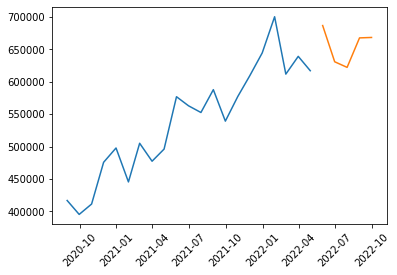

In [ ]:
plt.plot(train)
plt.plot(test)
plt.xticks(rotation=45)
plt.show()

## Auto-ARIMA train

In [ ]:
# to forecast multiple timesteps into the future
# we need to include the months as an exogenous variable to be forecasted as well

train['month_index'] = train.index.month
test['month_index'] = test.index.month

# SARIMAX model setup
# working with test_size = 0.8
# not working with test_size =0.7

SARIMAX_model_train = auto_arima(train[['Merchant 1']], 
                           exogenous=train[['month_index']],
                           start_p=1, 
                           start_q=1,
                           test='adf',
                           max_p=3, max_q=3, 
                           m=12,
                           start_P=0, 
                           seasonal=True,
                           d=None, 
                           D=1, 
                           trace=False,
                           error_action='warn',  
                           suppress_warnings=True, 
                           stepwise=True)

In [ ]:
SARIMAX_model_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   21
Model:             SARIMAX(1, 2, 1)x(0, 1, [], 12)   Log Likelihood                 -86.693
Date:                             Tue, 22 Nov 2022   AIC                            179.385
Time:                                     11:03:27   BIC                            179.223
Sample:                                 08-31-2020   HQIC                           177.380
                                      - 04-30-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6842      0.304     -2.250      0.024      -1.280      -0.088
ma.L1         -0.9373      0.064    -14.741      0.000      -1.062      -0.813
sigma2      3.356e+09   1.67e-11   2.01e+20      0.000    3.36e+09    3.36e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.90   Jarque-Bera (JB):                 1.26
Prob(Q):                              0.34   Prob(JB):                         0.53
Heteroskedasticity (H):               7.47   Skew:                             1.01
Prob(H) (two-sided):                  0.24   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.58e+36. Standard errors may be unstable.
"""

## Auto-ARIMA test

In [ ]:
# forecasting for n periods
# adding month_index for forecast_df
# adding train and test splits into function

def sarimax_forecast_train(SARIMAX_model, train, test, periods=test_rows):

    # forecast
    n_periods = periods

    df = train.copy(deep=True) # taking only train part same df name
                               # to fasten code reproduction

    forecast_df = pd.DataFrame({"month_index":pd.date_range(df.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=forecast_df[['month_index']])
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    #fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(20,10))
    plt.plot(df["Merchant 1"], color='#1f76b4')
    plt.plot(fitted, color='darkgreen')
    plt.plot(test, color='#1f76b4')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Transactions")
    plt.show()

    # error
    results = pd.DataFrame({'historical' : test['Merchant 1'].values,
                            'prediction' : fitted.values})
    print(results)
    rmse = sqrt(sklearn.metrics.mean_squared_error(results['historical'].values, results['prediction'].values))
    print('Test RMSE: %.3f' % rmse)

In [ ]:
# predict

SARIMAX_model_train.predict(n_periods=test_rows)

2022-05-31    722782.644514
2022-06-30    688795.963321
2022-07-31    689336.215593
2022-08-31    714288.783405
2022-09-30    669977.260828
Freq: M, dtype: float64

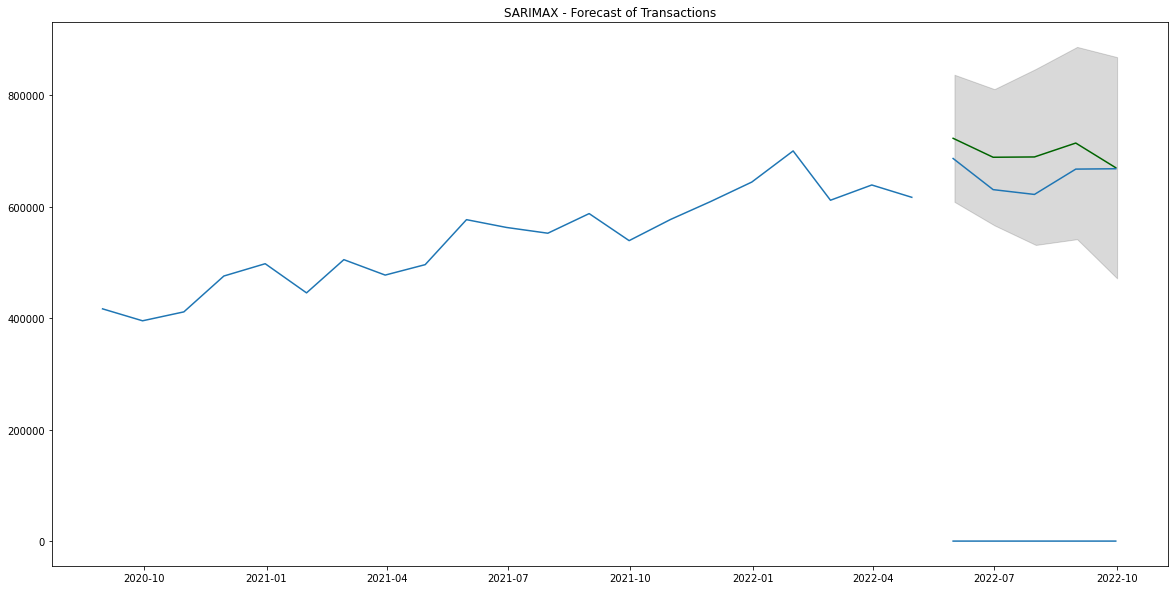

   historical     prediction
0    686572.0  722782.644514
1    630707.0  688795.963321
2    622073.0  689336.215593
3    667523.0  714288.783405
4    668189.0  669977.260828
Test RMSE: 47749.586


In [ ]:
# comparing actual test vs predict

sarimax_forecast_train(SARIMAX_model_train, train, test, periods=test_rows)

## 12 months prediction

In [ ]:
# SARIMAX model setup
# full df monthly datanpoints

df['month_index'] = df.index.month

SARIMAX_model_prediction = auto_arima(df[['Merchant 1']], exogenous=df[['month_index']],
                           start_p=1, 
                           max_p=3,
                           start_q=1, 
                           max_q=3,
                           d=None,
                           max_d=2,
                           start_P=1,
                           max_P=2,
                           start_Q=1,
                           max_Q=2,
                           D=1,
                           max_D=2,
                           m=12,  
                           seasonal=True,
                           test='adf',
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

In [ ]:
SARIMAX_model_prediction.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   26
Model:             SARIMAX(1, 2, 1)x(0, 1, 1, 12)   Log Likelihood                -146.113
Date:                            Tue, 22 Nov 2022   AIC                            300.226
Time:                                    11:03:40   BIC                            302.165
Sample:                                08-31-2020   HQIC                           299.508
                                     - 09-30-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6703      0.298     -2.246      0.025      -1.255      -0.085
ma.L1         -0.9059      0.110     -8.243      0.000      -1.121      -0.691
ma.S.L12      -0.2000      0.283     -0.706      0.480      -0.756       0.355
sigma2      2.899e+09   1.91e-11   1.52e+20      0.000     2.9e+09     2.9e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):                 3.87
Prob(Q):                              0.51   Prob(JB):                         0.14
Heteroskedasticity (H):               0.29   Skew:                             1.11
Prob(H) (two-sided):                  0.26   Kurtosis:                         4.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.26e+36. Standard errors may be unstable.
"""

In [ ]:
# forecasting for n periods
# adding month_index for forecast_df

def sarimax_forecast(SARIMAX_model, periods=12):

    # forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month_index":pd.date_range(df.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, return_conf_int=True,
                                            # including exogenous variable
                                            exogenous=forecast_df[['month_index']])
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    #fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # plot
    plt.figure(figsize=(20,10))
    plt.plot(df["Merchant 1"], color='#1f76b4')
    plt.plot(fitted, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Transactions")
    plt.show()

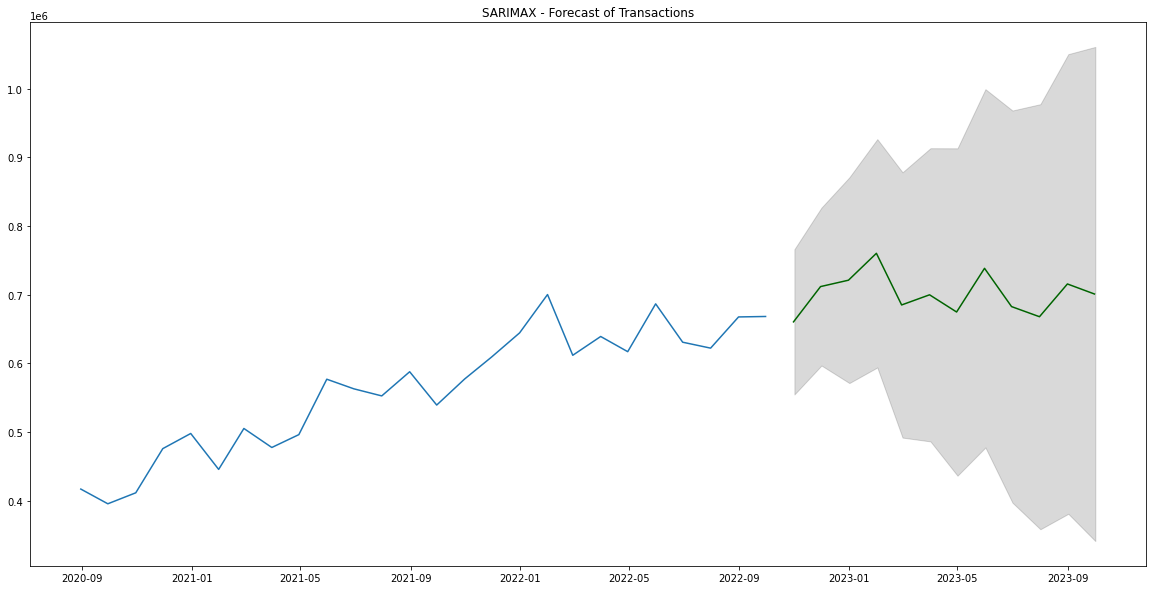

In [ ]:
sarimax_forecast(SARIMAX_model_prediction, periods=12)

# M30

In [ ]:
df = pd.DataFrame(data.T.iloc[:,29])
df.index.name = 'Month'
df.head()

,Merchant 30
Month,
2020-08-31,6707.0
2020-09-30,5951.0
2020-10-31,6399.0
2020-11-30,2859.0
2020-12-31,9847.0


## ADFT

In [ ]:
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df)

(0.019986186318754644, False)

## Train-test split

In [ ]:
train = pd.DataFrame({"Merchant 30" : df["Merchant 30"][:train_rows].values,
                      'Month' : df["Merchant 30"][:train_rows].index})
train = train.set_index('Month')
train.shape

(21, 1)

In [ ]:
test = pd.DataFrame({"Merchant 30" : df["Merchant 30"][train_rows:].values,
                      'Month' : df["Merchant 30"][train_rows:].index})
test = test.set_index('Month')
test.shape

(5, 1)

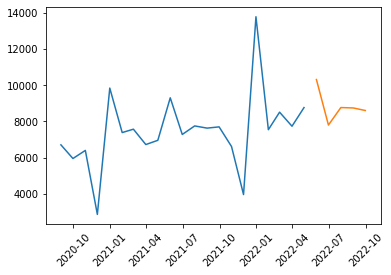

In [ ]:
plt.plot(train)
plt.plot(test)
plt.xticks(rotation=45)
plt.show()

## Auto-ARIMA train

In [ ]:
# to forecast multiple timesteps into the future
# we need to include the months as an exogenous variable to be forecasted as well

train['month_index'] = train.index.month
test['month_index'] = test.index.month

# SARIMAX model setup
# working with test_size = 0.8
# not working with test_size =0.7

SARIMAX_model_train = auto_arima(train[['Merchant 30']], 
                           exogenous=train[['month_index']],
                           start_p=1, 
                           start_q=1,
                           test='adf',
                           max_p=3, max_q=3, 
                           m=12,
                           start_P=0, 
                           seasonal=True,
                           d=None, 
                           D=1, 
                           trace=False,
                           error_action='warn',  
                           suppress_warnings=True, 
                           stepwise=True)

In [ ]:
SARIMAX_model_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   21
Model:             SARIMAX(1, 2, 0)x(1, 1, 0, 12)   Log Likelihood                 -63.224
Date:                            Tue, 22 Nov 2022   AIC                            132.447
Time:                                    11:03:57   BIC                            132.285
Sample:                                08-31-2020   HQIC                           130.441
                                     - 04-30-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5056      0.939     -0.538      0.590      -2.347       1.335
ar.S.L12       0.4837      0.836      0.579      0.563      -1.154       2.121
sigma2       3.76e+06   4.29e+06      0.877      0.380   -4.64e+06    1.22e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                 1.00
Prob(Q):                              0.62   Prob(JB):                         0.61
Heteroskedasticity (H):               0.25   Skew:                            -0.93
Prob(H) (two-sided):                  0.40   Kurtosis:                         3.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Auto-ARIMA test

In [ ]:
# forecasting for n periods
# adding month_index for forecast_df
# adding train and test splits into function

def sarimax_forecast_train(SARIMAX_model, train, test, periods=test_rows):

    # forecast
    n_periods = periods

    df = train.copy(deep=True) # taking only train part same df name
                               # to fasten code reproduction

    forecast_df = pd.DataFrame({"month_index":pd.date_range(df.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=forecast_df[['month_index']])
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    #fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(20,10))
    plt.plot(df["Merchant 30"], color='#1f76b4')
    plt.plot(fitted, color='darkgreen')
    plt.plot(test, color='#1f76b4')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Transactions")
    plt.show()

    # error
    results = pd.DataFrame({'historical' : test['Merchant 30'].values,
                            'prediction' : fitted.values})
    print(results)
    rmse = sqrt(sklearn.metrics.mean_squared_error(results['historical'].values, results['prediction'].values))
    print('Test RMSE: %.3f' % rmse)

In [ ]:
# predict

SARIMAX_model_train.predict(n_periods=test_rows)

2022-05-31    12683.696521
2022-06-30    10437.892669
2022-07-31    11911.781548
2022-08-31    11030.492244
2022-09-30    12652.304354
Freq: M, dtype: float64

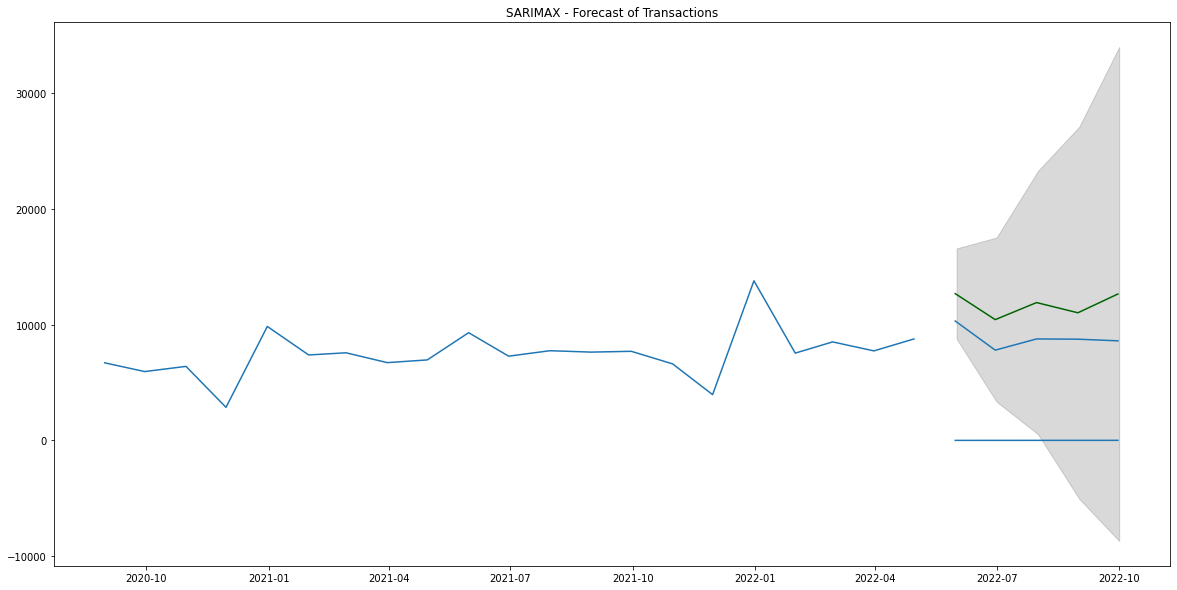

   historical    prediction
0     10319.0  12683.696521
1      7802.0  10437.892669
2      8770.0  11911.781548
3      8748.0  11030.492244
4      8607.0  12652.304354
Test RMSE: 2965.966


In [ ]:
# comparing actual test vs predict

sarimax_forecast_train(SARIMAX_model_train, train, test, periods=test_rows)

## 12 months prediction

In [ ]:
# SARIMAX model setup
# full df monthly datanpoints

df['month_index'] = df.index.month

SARIMAX_model_prediction = auto_arima(df[['Merchant 30']], exogenous=df[['month_index']],
                           start_p=1, 
                           max_p=3,
                           start_q=1, 
                           max_q=3,
                           d=None,
                           max_d=2,
                           start_P=1,
                           max_P=2,
                           start_Q=1,
                           max_Q=2,
                           D=1,
                           max_D=2,
                           m=12,  
                           seasonal=True,
                           test='adf',
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

In [ ]:
SARIMAX_model_prediction.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   26
Model:             SARIMAX(1, 2, 0)x(1, 1, 0, 12)   Log Likelihood                -106.911
Date:                            Tue, 22 Nov 2022   AIC                            219.821
Time:                                    11:04:02   BIC                            221.276
Sample:                                08-31-2020   HQIC                           219.283
                                     - 09-30-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5239      0.418     -1.255      0.210      -1.342       0.295
ar.S.L12       0.3655      0.345      1.059      0.290      -0.311       1.042
sigma2      2.959e+06   1.74e+06      1.704      0.088   -4.44e+05    6.36e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.55   Jarque-Bera (JB):                 2.96
Prob(Q):                              0.46   Prob(JB):                         0.23
Heteroskedasticity (H):               0.17   Skew:                            -1.17
Prob(H) (two-sided):                  0.12   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# forecasting for n periods
# adding month_index for forecast_df

def sarimax_forecast(SARIMAX_model, periods=12):

    # forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month_index":pd.date_range(df.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, return_conf_int=True,
                                            # including exogenous variable
                                            exogenous=forecast_df[['month_index']])
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    #fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # plot
    plt.figure(figsize=(20,10))
    plt.plot(df["Merchant 30"], color='#1f76b4')
    plt.plot(fitted, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Transactions")
    plt.show()

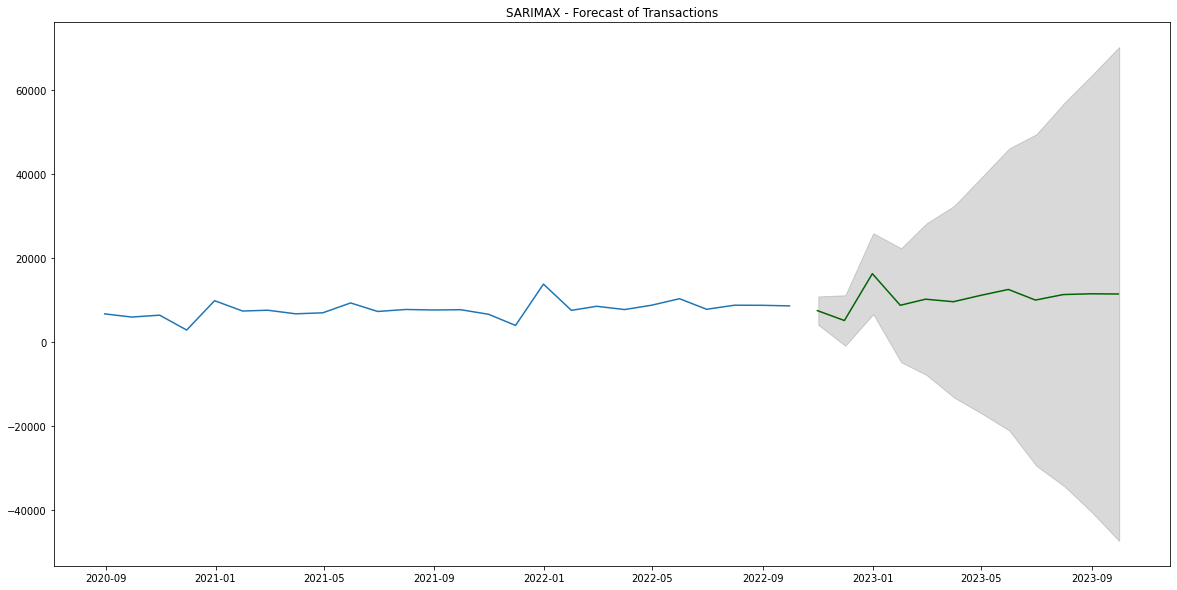

In [ ]:
sarimax_forecast(SARIMAX_model_prediction, periods=12)

# M99

In [ ]:
df = pd.DataFrame(data.T.iloc[:,98])
df.index.name = 'Month'
df.head()

,Merchant 99
Month,
2020-08-31,3.0
2020-09-30,13.0
2020-10-31,55.0
2020-11-30,8.0
2020-12-31,1.0


## ADFT

In [ ]:
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df)

(0.1178157065995966, True)

## Train-test split

In [ ]:
train = pd.DataFrame({"Merchant 99" : df["Merchant 99"][:train_rows].values,
                      'Month' : df["Merchant 99"][:train_rows].index})
train = train.set_index('Month')
train.shape

(21, 1)

In [ ]:
test = pd.DataFrame({"Merchant 99" : df["Merchant 99"][train_rows:].values,
                      'Month' : df["Merchant 99"][train_rows:].index})
test = test.set_index('Month')
test.shape

(5, 1)

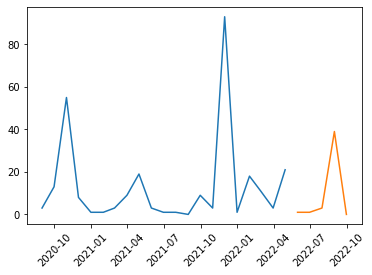

In [ ]:
plt.plot(train)
plt.plot(test)
plt.xticks(rotation=45)
plt.show()

## Auto-ARIMA train

In [ ]:
# to forecast multiple timesteps into the future
# we need to include the months as an exogenous variable to be forecasted as well

train['month_index'] = train.index.month
test['month_index'] = test.index.month

# SARIMAX model setup
# working with test_size = 0.8
# not working with test_size =0.7

SARIMAX_model_train = auto_arima(train[['Merchant 99']], 
                           exogenous=train[['month_index']],
                           start_p=1, 
                           start_q=1,
                           test='adf',
                           max_p=3, max_q=3, 
                           m=12,
                           start_P=0, 
                           seasonal=True,
                           d=None, 
                           D=1, 
                           trace=False,
                           error_action='warn',  
                           suppress_warnings=True, 
                           stepwise=True)

In [ ]:
SARIMAX_model_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   21
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                 -44.483
Date:                  Tue, 22 Nov 2022   AIC                             90.966
Time:                          11:04:06   BIC                             91.163
Sample:                      08-31-2020   HQIC                            90.540
                           - 04-30-2022                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1149.6102    382.688      3.004      0.003     399.555    1899.665
===================================================================================
Ljung-Box (L1) (Q):                   2.35   Jarque-Bera (JB):                 2.20
Prob(Q):                              0.13   Prob(JB):                         0.33
Heteroskedasticity (H):               0.04   Skew:                             0.94
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Auto-ARIMA test

In [ ]:
# forecasting for n periods
# adding month_index for forecast_df
# adding train and test splits into function

def sarimax_forecast_train(SARIMAX_model, train, test, periods=test_rows):

    # forecast
    n_periods = periods

    df = train.copy(deep=True) # taking only train part same df name
                               # to fasten code reproduction

    forecast_df = pd.DataFrame({"month_index":pd.date_range(df.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=forecast_df[['month_index']])
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    #fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(20,10))
    plt.plot(df["Merchant 99"], color='#1f76b4')
    plt.plot(fitted, color='darkgreen')
    plt.plot(test, color='#1f76b4')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Transactions")
    plt.show()

    # error
    results = pd.DataFrame({'historical' : test['Merchant 99'].values,
                            'prediction' : fitted.values})
    print(results)
    rmse = sqrt(sklearn.metrics.mean_squared_error(results['historical'].values, results['prediction'].values))
    print('Test RMSE: %.3f' % rmse)

In [ ]:
# predict

SARIMAX_model_train.predict(n_periods=test_rows)

2022-05-31    3.0
2022-06-30    1.0
2022-07-31    1.0
2022-08-31    0.0
2022-09-30    9.0
Freq: M, dtype: float64

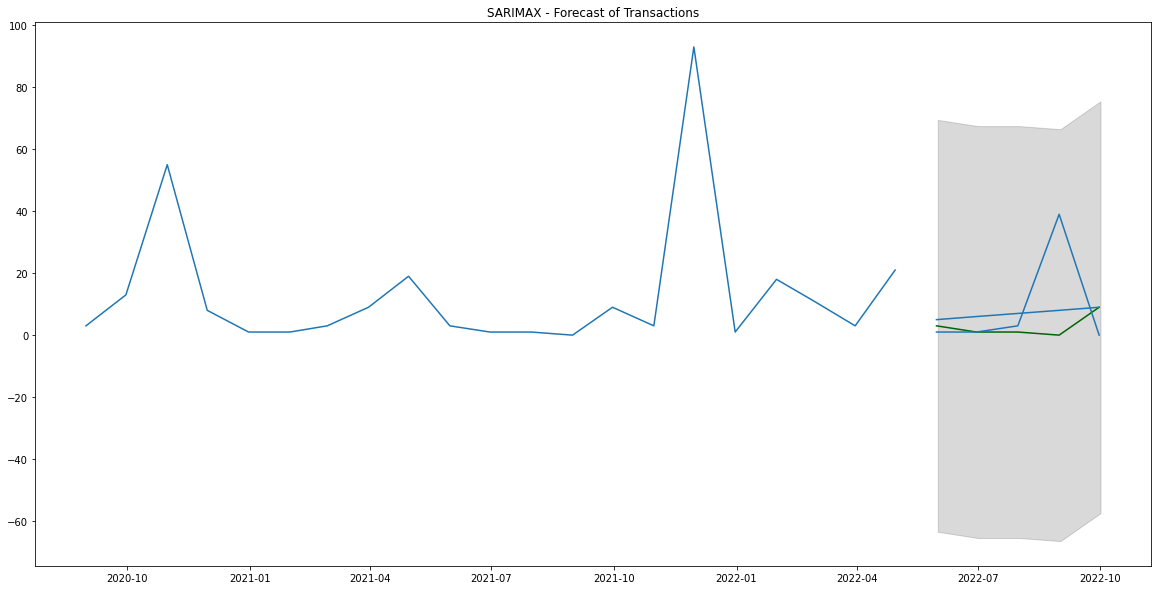

   historical  prediction
0         1.0         3.0
1         1.0         1.0
2         3.0         1.0
3        39.0         0.0
4         0.0         9.0
Test RMSE: 17.944


In [ ]:
# comparing actual test vs predict

sarimax_forecast_train(SARIMAX_model_train, train, test, periods=test_rows)

## 12 months prediction

In [ ]:
# SARIMAX model setup
# full df monthly datanpoints

df['month_index'] = df.index.month

SARIMAX_model_prediction = auto_arima(df[['Merchant 99']], exogenous=df[['month_index']],
                           start_p=1, 
                           max_p=3,
                           start_q=1, 
                           max_q=3,
                           d=None,
                           max_d=2,
                           start_P=1,
                           max_P=2,
                           start_Q=1,
                           max_Q=2,
                           D=1,
                           max_D=2,
                           m=12,  
                           seasonal=True,
                           test='adf',
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

In [ ]:
SARIMAX_model_prediction.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   26
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                 -67.115
Date:                  Tue, 22 Nov 2022   AIC                            136.230
Time:                          11:04:09   BIC                            136.870
Sample:                      08-31-2020   HQIC                           136.171
                           - 09-30-2022                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       853.9744    202.831      4.210      0.000     456.432    1251.516
===================================================================================
Ljung-Box (L1) (Q):                   3.14   Jarque-Bera (JB):                 6.17
Prob(Q):                              0.08   Prob(JB):                         0.05
Heteroskedasticity (H):               0.16   Skew:                             1.04
Prob(H) (two-sided):                  0.07   Kurtosis:                         5.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# forecasting for n periods
# adding month_index for forecast_df

def sarimax_forecast(SARIMAX_model, periods=12):

    # forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month_index":pd.date_range(df.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, return_conf_int=True,
                                            # including exogenous variable
                                            exogenous=forecast_df[['month_index']])
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    #fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # plot
    plt.figure(figsize=(20,10))
    plt.plot(df["Merchant 99"], color='#1f76b4')
    plt.plot(fitted, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Transactions")
    plt.show()

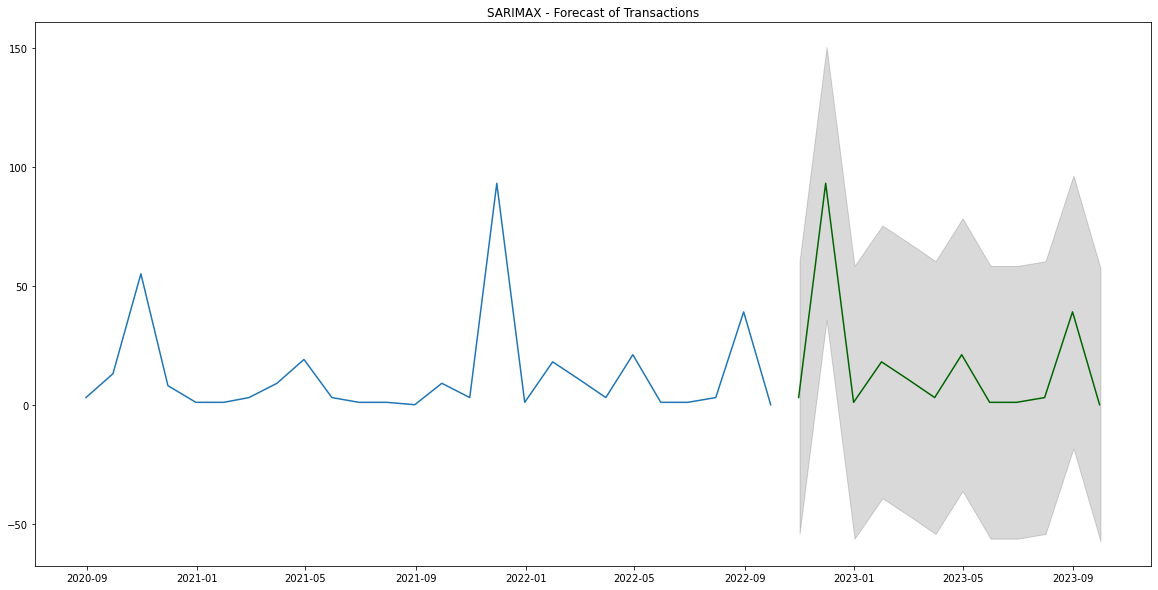

In [ ]:
sarimax_forecast(SARIMAX_model_prediction, periods=12)